In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:

# Load the dataset
file_path = "/content/synthetic_brain_tumor_dataset.csv"  # Ensure this file is in the same directory
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


,Patient_ID,Time_Day,Age,Gender,Tumor_Type,Tumor_Location,Tumor_Size_mm3,Tumor_Diameter_mm,Edema_Size_mm3,Necrosis_Percentage,Enhancing_Tumor_Percentage,Blood_Supply_Index,Growth_Rate_mm3/day,Number_of_Cells_in_Sample
0,P0001,0,23,Male,Pituitary tumor,Occipital Lobe,792.430,9.25,62.61,22.67,25.21,0.581,4.971,1576538.0
1,P0001,30,23,Male,Pituitary tumor,Occipital Lobe,797.401,9.27,177.15,12.35,55.84,1.025,4.971,2237899.0
2,P0001,60,23,Male,Pituitary tumor,Occipital Lobe,802.372,9.29,208.54,7.49,14.32,0.549,4.971,1277590.0
3,P0001,90,23,Male,Pituitary tumor,Occipital Lobe,807.343,9.31,164.76,12.12,52.35,1.046,4.971,1244157.0
4,P0001,120,23,Male,Pituitary tumor,Occipital Lobe,812.314,9.33,136.10,17.09,36.26,1.053,4.971,1609492.0


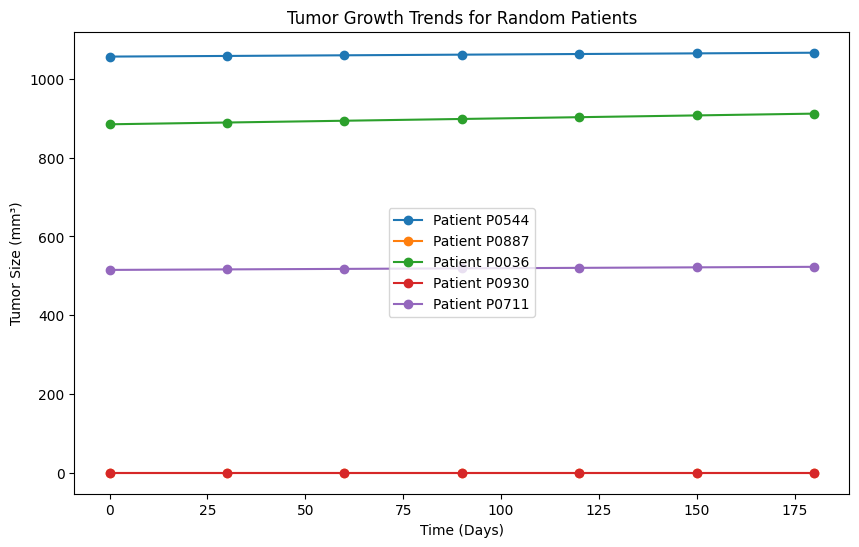

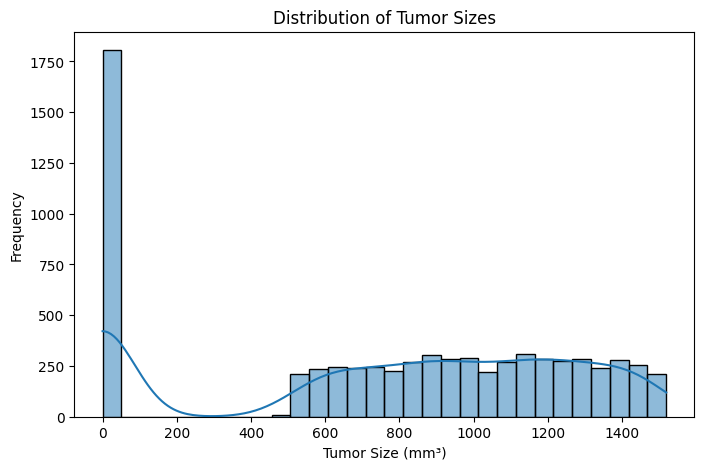

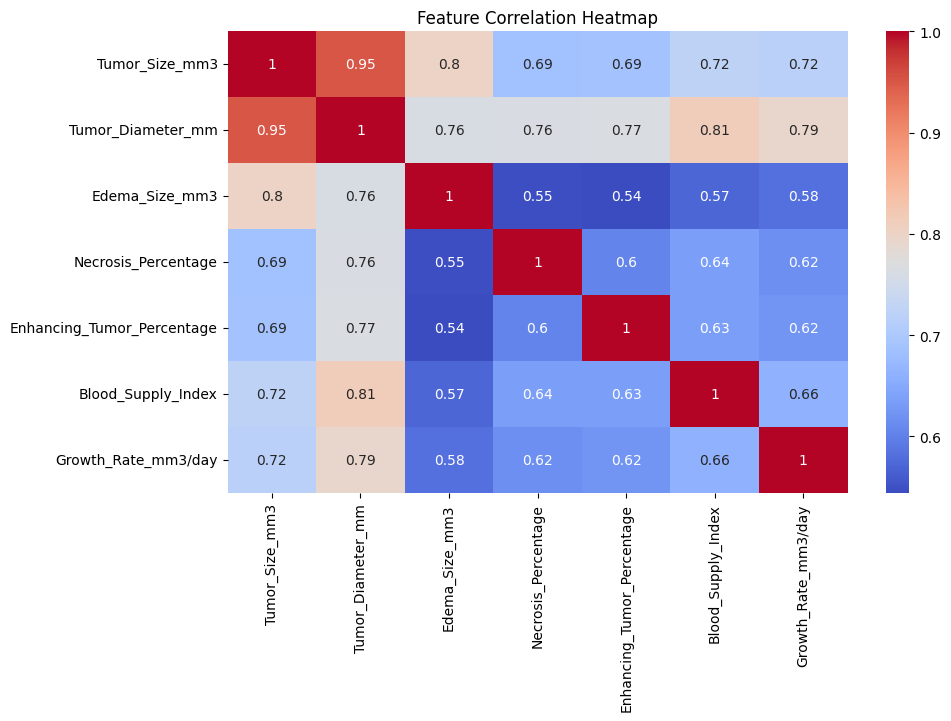

In [3]:

# Visualizing Tumor Growth Trends for 5 Random Patients
plt.figure(figsize=(10, 6))
random_patients = np.random.choice(df['Patient_ID'].unique(), 5, replace=False)

for patient in random_patients:
    patient_data = df[df["Patient_ID"] == patient]
    plt.plot(patient_data["Time_Day"], patient_data["Tumor_Size_mm3"], marker='o', label=f"Patient {patient}")

plt.xlabel("Time (Days)")
plt.ylabel("Tumor Size (mm³)")
plt.title("Tumor Growth Trends for Random Patients")
plt.legend()
plt.show()

# Tumor Size Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Tumor_Size_mm3"], bins=30, kde=True)
plt.xlabel("Tumor Size (mm³)")
plt.ylabel("Frequency")
plt.title("Distribution of Tumor Sizes")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[["Tumor_Size_mm3", "Tumor_Diameter_mm", "Edema_Size_mm3", "Necrosis_Percentage",
                "Enhancing_Tumor_Percentage", "Blood_Supply_Index", "Growth_Rate_mm3/day"]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [4]:

# Select relevant features for LSTM
features = ["Tumor_Size_mm3", "Tumor_Diameter_mm", "Edema_Size_mm3", "Necrosis_Percentage",
            "Enhancing_Tumor_Percentage", "Blood_Supply_Index", "Growth_Rate_mm3/day"]
target = "Tumor_Size_mm3"  # Predicting future tumor size

# Normalize the features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Sort data by Patient_ID and Time_Day
df = df.sort_values(by=["Patient_ID", "Time_Day"])

# Split data into sequences for LSTM
sequence_length = 5  # Use last 5 time steps to predict the next
X, y = [], []

# Group by Patient_ID to create sequences
for _, patient_data in df.groupby("Patient_ID"):
    patient_data = patient_data[features + [target]].values
    for i in range(len(patient_data) - sequence_length):
        X.append(patient_data[i:i + sequence_length, :-1])  # Input features
        y.append(patient_data[i + sequence_length, -1])  # Target variable

X, y = np.array(X), np.array(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}, Testing shape: {X_test.shape}")


Training shape: (1600, 5, 7), Testing shape: (400, 5, 7)


Tumor Types: ['Pituitary tumor' 'Glioma' 'No tumor' 'Meningioma']


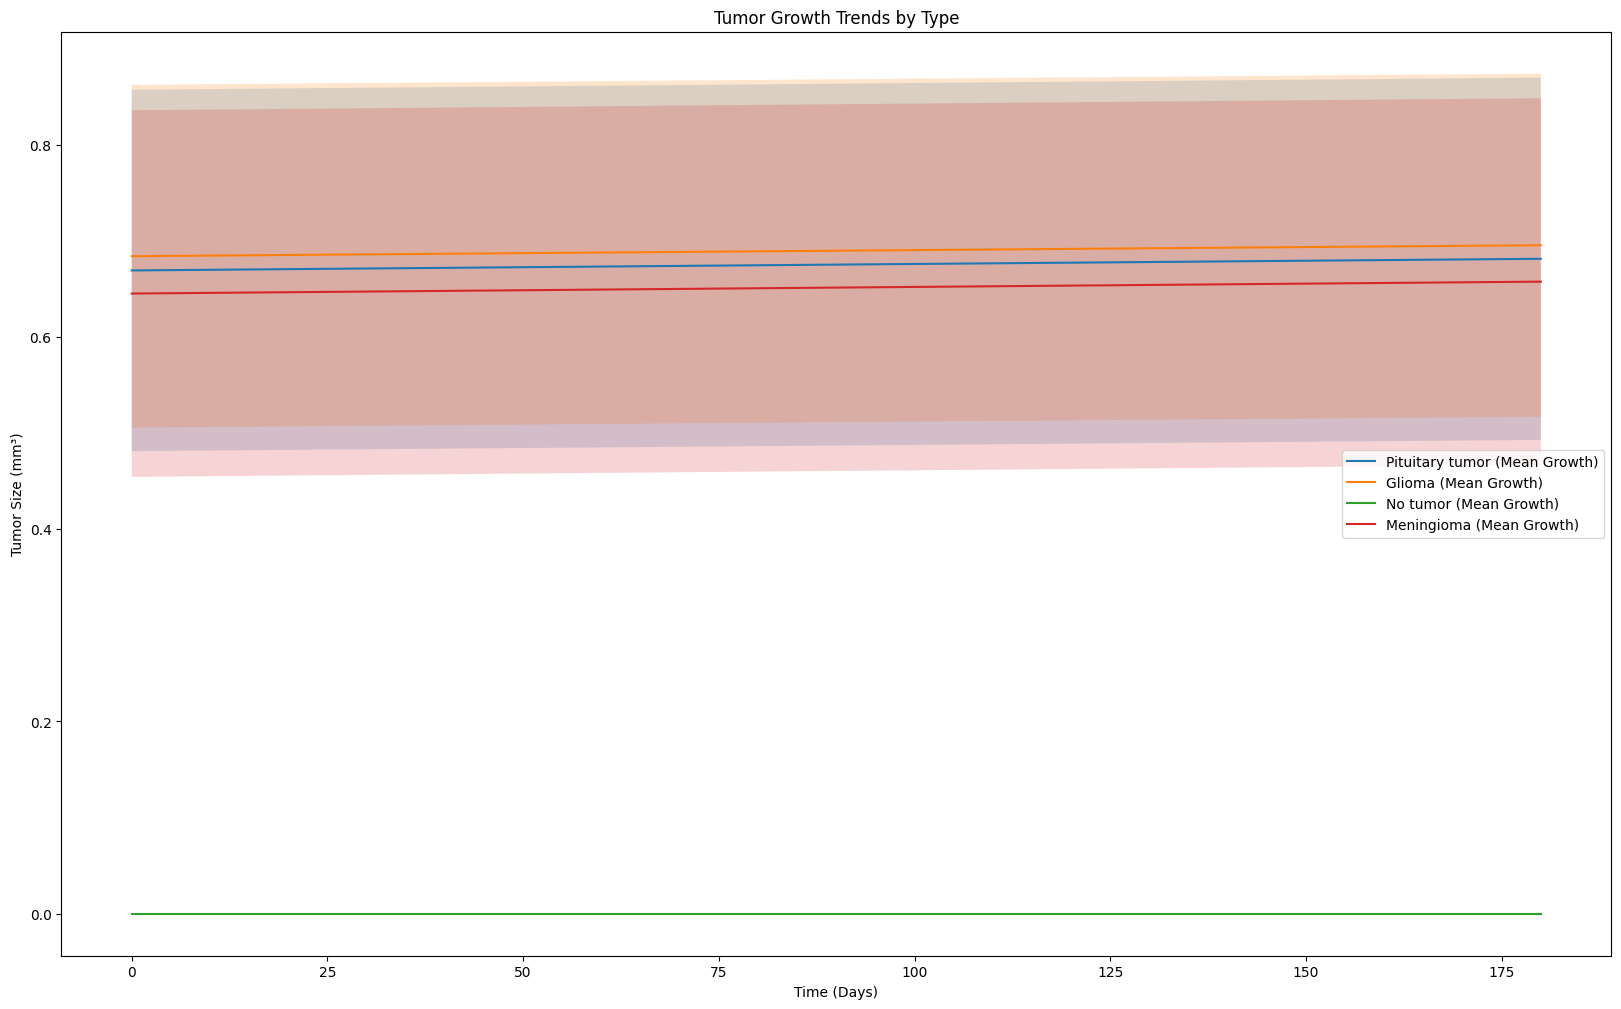

In [5]:

# Identify unique tumor types in the dataset
if 'Tumor_Type' in df.columns:
    unique_tumor_types = df['Tumor_Type'].unique()
    print("Tumor Types:", unique_tumor_types)

    # Visualize tumor growth trends for different tumor types
    plt.figure(figsize=(20, 12))

    for tumor_type in unique_tumor_types:
        subset = df[df["Tumor_Type"] == tumor_type].groupby("Time_Day")["Tumor_Size_mm3"].agg(['mean', 'std'])

        plt.plot(subset.index, subset['mean'], label=f"{tumor_type} (Mean Growth)")
        plt.fill_between(subset.index, subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.2)

    plt.xlabel("Time (Days)")
    plt.ylabel("Tumor Size (mm³)")
    plt.title("Tumor Growth Trends by Type")
    plt.legend()
    plt.show()
else:
    print("No 'Tumor_Type' column found in the dataset. Ensure the dataset includes tumor type information.")


In [6]:

# Define the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Save the trained model
model.save("tumor_growth_lstm_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.1709 - val_loss: 0.0110
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0102 - val_loss: 0.0018
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - val_loss: 3.5443e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 9.8211e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 
Test Loss (MSE): 0.0011896808864548802


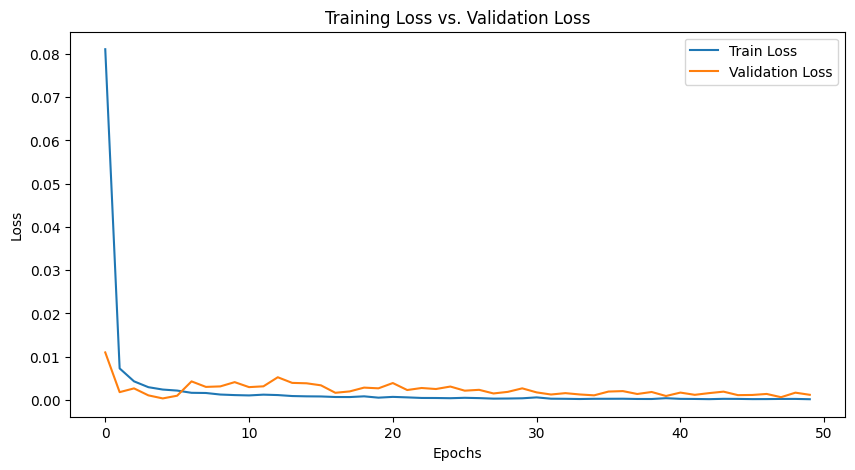

In [7]:

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs. Validation Loss')
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


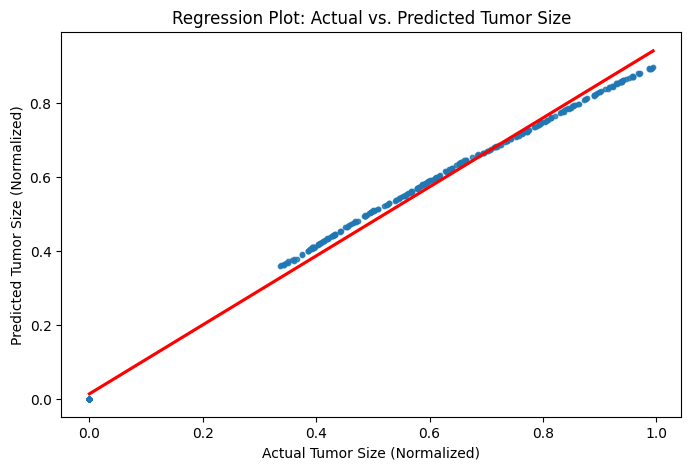

In [8]:

# Make predictions
y_pred = model.predict(X_test)

# Regression Plot: Actual vs. Predicted Tumor Size
plt.figure(figsize=(8, 5))
sns.regplot(x=y_test, y=y_pred.flatten(), scatter_kws={"s": 10}, line_kws={"color": "red"})
plt.xlabel("Actual Tumor Size (Normalized)")
plt.ylabel("Predicted Tumor Size (Normalized)")
plt.title("Regression Plot: Actual vs. Predicted Tumor Size")
plt.show()
